# Music Genre Classification

## 2. Recurrent Neural Network Implementation

Fabrizio Niro 5106988 - Jacopo Signò 5111043

GTZAN Dataset - Music Genre Classification 

https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

In [1]:
pip install -q d2l==1.0.0a1.post0

     |████████████████████████████████| 93 kB 1.4 MB/s 
     |████████████████████████████████| 121 kB 69.9 MB/s 
     |████████████████████████████████| 1.6 MB 34.6 MB/s 
     |████████████████████████████████| 83 kB 2.9 MB/s 


In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import pickle
import numpy as np
from d2l import torch as d2l
from torch.utils import data
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/GitHub/deepl_project

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1-5eanNG8kkYHMlUZjA6z2dSvwRdzkj4_/deepl_project


**We load the data pre-processed in the notebook "data_preprocess.ipynb"**

In [3]:
with open('Processed_data/data_train', 'rb') as f:
    data_train = pickle.load(f)
with open('Processed_data/data_test', 'rb') as f:
    data_test = pickle.load(f)

# Loading data



In [4]:
batch_size = 128
# Training iterable
train_iter = data.DataLoader(data_train, batch_size, shuffle=True, drop_last=True)
# Testing iterable
test_iter = data.DataLoader(data_test, batch_size, shuffle=False, drop_last=True)

# Neural Network 

## Gated Recurrent Unit (GRU)

A gated recurrent unit (GRU) is a type of recurrent block that was introduced in 2014
by Kyunghyun Cho, as an improvement over LSTM. A GRU unit
usually has similar or better performance to a LSTM, but it does so with fewer parameters and operations, thus leading to significantly faster computation.

The key point that distinguishes from Vanilla RNN is the fact GRU uses gates to control the flow of information. In particular in GRU architechture we have 2 gates:
- A reset gate, $r_t$ , which uses the previous cell state $h_{t-1}$ and the network input $x_{t}$ to control how much of the previous state we might still want to remember.

- An update gate $z_{t}$ that decides what information to discard and what new information to include in its place, allowing us to control how much of the new state is just a copy of the old state.

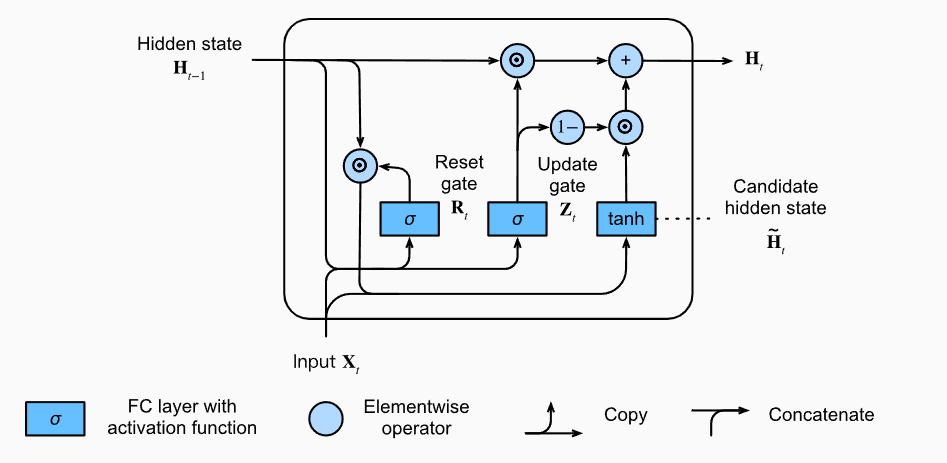

We define the class of our model, which is composed of 2 *GRU* layers and 3 *Dense (Linear)* layers, with *LeakyReLU* activation function and *LogSoftmax* for returning log probabilities at the end.

*LeakyReLU* has a small slope for negative values, instead of zero. In our case, leaky ReLU has y = 0.01x when x < 0.

Leaky *ReLU* has two benefits:

It fixes the “dying ReLU” problem, as it doesn’t have zero-slope parts. It speeds up training. Unlike ReLU, leaky ReLU is more “balanced,” and may therefore learn faster.


*Log softmax* is advantageous over softmax for improved numerical performance and gradient optimization. Log softmax is the log of softmax function. The reason of using log-softmax over softmax is the use of log probabilities over probabilities. The use of log probabilities means representing probabilities on a logarithmic scale, instead of the standard unit interval. Since the probabilities of independent events multiply, and logarithms convert multiplication to addition, log probabilities of independent events add. Log probabilities are thus practical for computations.




In [5]:
class Model(nn.Module):
    def __init__(
        self, input_size, hidden_size, num_layers, dropout_gru, dropout_seq, device):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_gru = dropout_gru
        self.dropout_seq = dropout_seq
        self.device = device

        # GRU layers
        self.gru = nn.GRU(
            
            input_size=self.input_size, 
            hidden_size=self.hidden_size,
            num_layers=self.num_layers, 
            bias=True,
            batch_first=True,
            dropout=self.dropout_gru,
            bidirectional=False

            )
        
        # Sequential Dense layers
        self.seq = nn.Sequential(
            
            nn.Linear(self.hidden_size, 128),
            # LeakyReLU helps preventing vanishing gradient 
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(p=self.dropout_seq),
            nn.Linear(128,64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(64, 10), 
            # LogSoftmax penalizes more errors
            nn.LogSoftmax()

            )
    # 
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.seq(out[:,-1])
        return out
    # Sets weights of the GRU 
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(
            self.num_layers,
            batch_size,
            self.hidden_size
            ).zero_().to(self.device)
        return hidden

# Evaluate accuracy and Training function

For training we use a revisited version of the functions provided by the book d2l.ai. 

In particular, we add the possibility to initialize the hidden state of the GRU architecture and the Gradient clipping method from torch.utils class. It has the task of preventing the exploding gradient issue, by truncating the gradient value to 1 at each iteration.

In [6]:
def evaluate_accuracy_gpu(net, data_iter, h, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""

    if isinstance(net, torch.nn.Module): # check if the is a torch.nn.Module
        net.eval()  # Set the model to evaluation mode

        if not device:
            device = next(iter(net.parameters())).device

    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    for X, y in data_iter:
      X = X.to(device)
      y = y.to(device)
      metric.add(d2l.accuracy(net(X, h), y), y.numel())

    return metric[0] / metric[1]

In [ ]:
def train(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train a model with a GPU"""

    print('training on', device)
    # MOVE the net to the GPU (if available)
    net.to(device) 
    # Stochastic Gradient Descent optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # Cross Entropy Loss
    loss = nn.CrossEntropyLoss()
    
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    # initialize hidden state of the GRU layers
    h = net.init_hidden(batch_size)

    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        # Set the network to training mode (not evaluation mode)
        net.train() 

        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # MOVE each minibatch of data to the GPU (if available)
            X, y = X.to(device), y.to(device) 
            y_hat = net(X, h)
            l = loss(y_hat, y.type(torch.long))
            l.backward()
            # Gradient clipping avoids exploding gradient issues
            torch.nn.utils.clip_grad_value_(net.parameters(), 1)
            optimizer.step()
            # detach gradient calculation for avoiding effect on backpropagation calculation
            with torch.no_grad(): 
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
                
        test_acc = evaluate_accuracy_gpu(net, test_iter, h)

        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

# Model

In [ ]:
net = Model(
    # Input size (MFCC features)
    input_size = data_train[0][0].shape[1],
    # Hidden state size 
    hidden_size = 128,
    # Number of GRU layers
    num_layers = 2,
    # Droput for GRU layers
    dropout_gru = 0.2,
    # Dropout for Sequential layers
    dropout_seq = 0.2,
    # Device is GPU if available, else CPU
    device = d2l.try_gpu())

print(f'Model summary: \n\n {net}')

# Network Training

loss 0.688, train acc 0.756, test acc 0.680
33373.3 examples/sec on cuda:0


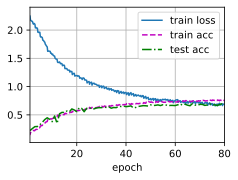

In [ ]:
# Learning rate and Number of epochs
lr, num_epochs = 0.3, 80
# Call the train function to start training the model
train(net, train_iter, test_iter, num_epochs, lr)

In [ ]:
# Save trained model
torch.save(net, 'gru_model.pt')

In [ ]:
# Load trained model
net = torch.load('gru_model.pt')
# Set in evaluation mode
net.eval()

Model(
  (gru): GRU(20, 128, num_layers=2, batch_first=True, dropout=0.2)
  (seq): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=64, out_features=10, bias=True)
    (6): LogSoftmax(dim=None)
  )
)

# Model Testing 

In [ ]:
def test(net, test_iter, device = d2l.try_gpu()):
    '''Returns arrays for predictions and true labels'''
    # Move the model to GPU if available
    net.to(device)
    y_pred = []
    y_test = []
    for i, (X, y) in enumerate(test_iter):
      # Move X and targets to GPU if available
      X, y = X.to(device), y.to(device)
      # Compute predictions with trained model
      outputs = net(X, net.init_hidden(batch_size))
      # compute argmax of probability array
      _, preds = torch.max(outputs, 1)
      # Move predictions and true targets to CPU
      preds = preds.cpu().numpy()
      y = y.cpu().numpy()
      # Append preds of current batch to list
      y_pred.append(preds)
      # Append true target of current batch to list
      y_test.append(y)
    # Convert into numpy arrays and concatenate sublists in single array
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    y_pred = np.concatenate(y_pred)
    y_test = np.concatenate(y_test)
    # Compute overall test accuracy
    test_acc = np.count_nonzero(
        y_pred == y_test) / (batch_size * len(test_iter))
    # returns predictions, true target labels and test accuracy
    return y_pred, y_test, test_acc

y_pred, y_test, test_acc = test(net, test_iter)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


## Test accuracy

In [ ]:
print(f'Test accuracy: {test_acc: .2f}')

Test accuracy:  0.68


## Confusion matrix

 Genre | Blues | Clasical | Country |Disco |HipHop | Jazz | Metal | Pop | Raggae | Rock 
--|--|--|--|--|--|--|--|--|--|--|
   Numeric label   |  0| 1 |2 | 3 |4 |5 | 6 |7 | 8 | 9 


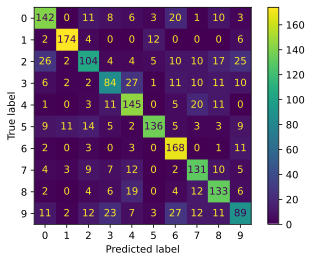

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


# Conclusion

The goal of the project was modelling Audio data with a Recurrent Neural Network, to build a music genre classifier. The project has been truly challenging due to the complexity of working with audio data, which requires advanced domain knowledge to identify and extract the correct features. An additional challenge has been the reduced size of the dataset. This resulted in poor generalization performances of the different architectures tried, leading us to experiment several data augmentation techniques and hyperparameters tuning.

We managed to reach an accuracy on test data of around 70%, that seems to be in line with other projects developed by the community.

Looking closer at the confusion matrix, it is noticeable how the model makes most of the prediction errors when dealing with genres having similar sounds, such as: (Disco, HipHop), (Rock, Metal) etc.

In the future, we aim to keep improving this project. We will try state of the art architectures, feeded with a much larger amount of data. 



